In [2]:
!pip install skyfield

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.0/446.0 kB 5.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# readjust padding
import matplotlib as mpl
mpl.rcParams['savefig.pad_inches'] = 0.2
import seaborn as sns

# custom
from image_generator import plot_sky, show_training_grid, get_waypoints, create_times_array
from utilities import mercator_distance

# skyfield
from skyfield.api import Topos


# I. Exploratory Data Analysis Notebook

The purpose of this notebook is to introduce marine navigation to the reader, as well as to outline the approach to creating a modern automated celestial navigation solution.

---

Number of unique waypoints:  11


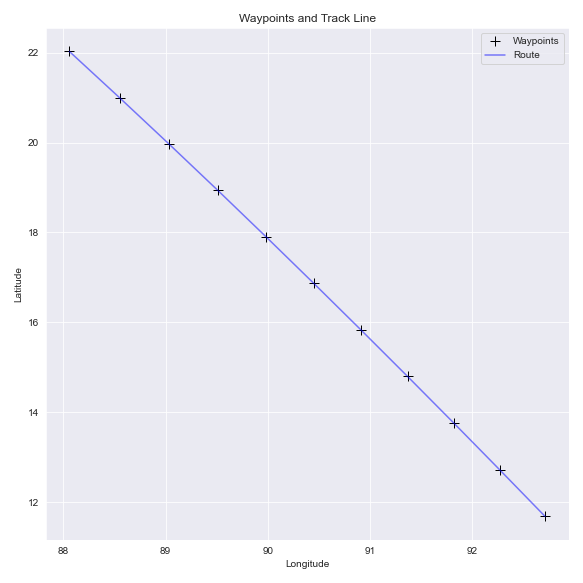

In [14]:
# define starting and ending positions
start = (22.0250, 88.0583)
end = (11.6833, 92.7167)

# get waypoints
waypoints = get_waypoints(start, end, 10, list_of_mile_displacements=[0])

# use seaborn darkgrid
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,8))

# use '+' symbol for waypoints
ax.plot(waypoints[:,1], waypoints[:,0], 'k+', markersize=10, label='Waypoints')
ax.plot(waypoints[:,1], waypoints[:,0], label='Route', color='blue', alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Waypoints and Track Line')
ax.legend()
fig.tight_layout();

Plotted above we see our voyage track line and waypoints along the track. 

#  II. Building the Training Position Arrays

In [17]:
def show_training_grid(start, end, points_along_track=100, displacements=10, displacement_interval=1):

    # get waypoints
    flat_track = get_waypoints(start, end, points_along_track, [x for x in range(0,displacements,displacement_interval)])
     
    # use seaborn darkgrid
    sns.set_style("darkgrid")
    
    # plot points in flat_track
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(flat_track[:, 1], flat_track[:, 0], s=1, c='red')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Training Grid')

    ax.plot(waypoints[:,1], waypoints[:,0], 'k+', markersize=10, label='Waypoints')

    plt.tight_layout()

    # make backround blue
    # ax.set_facecolor('xkcd:light blue')

    # show plot
    plt.show()

# Adding Spatial Dimension

Number of unique waypoints:  1919


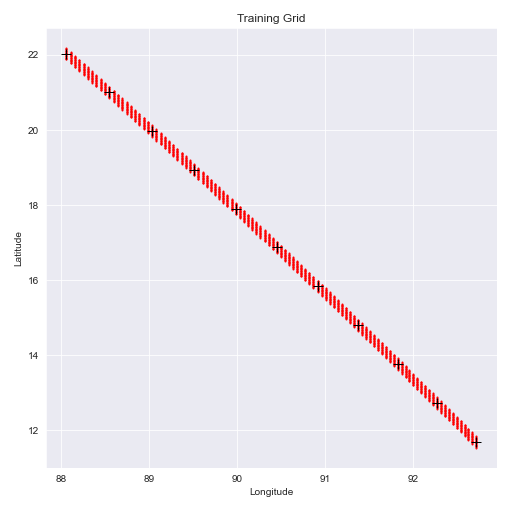

In [18]:
# show training grid
show_training_grid(start=start, end=end, points_along_track=100, displacements=10, displacement_interval=1)

In [20]:
# get waypoints
waypoints = get_waypoints(start, end, 100, list_of_mile_displacements=[0])

# average distance between waypoints
avg_dist = np.mean([mercator_distance(waypoints[i], waypoints[i+1]) for i in range(len(waypoints)-1)])

print(f'Average distance between waypoints: {avg_dist:.2f} miles')

Number of unique waypoints:  101
Average distance between waypoints: 6.76 miles


# Adding Temporal Dimension

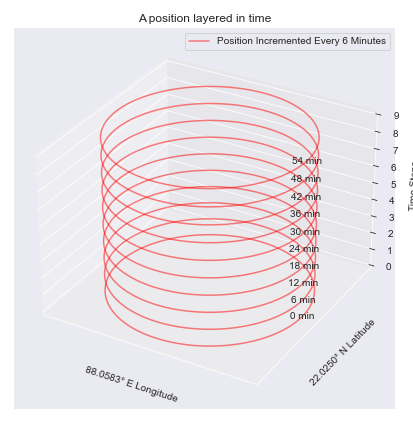

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def spatio_temporal(N=10, r=1, ax=None):
    # use seaborn darkgrid
    sns.set_style("darkgrid")
    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111, projection='3d')
        
    theta = np.linspace(0, 2*np.pi, 100)
    for i in range(N):
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        z = np.ones_like(x) * i
        ax.plot(x, y, z, '-r', alpha=0.5)
        
        # plot label of 6 minute intervals, rotate 90 degrees, place at 0,0,0
        ax.text(1, 0, i, f'{i*6} min', rotation=90, horizontalalignment='center', verticalalignment='center')
        plt.legend(['Position Incremented Every 6 Minutes'])
    
    # set labels
    ax.set_xlabel('88.0583° E Longitude')
    ax.set_ylabel('22.0250° N Latitude')
    ax.set_zlabel('Time Steps')
    ax.set_title('A position layered in time')

    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

spatio_temporal()




### Time Increments

Traditionally the position of a ship is fixed at a regular interval that is some increment of 6 minutes, as this allows for the navigator to make rapid and convenient mental speed/time/distance calculations, since 6 minutes is 1/10th of an hour. This shipboard tradition carries over to many other tasks -- log keeping is always done in increments of 6 minutes, rounding up or down as required. 

Thus, for each position in the training grid, we will create an image of the sky for every 6 minutes for a period of 4 hours, a standard navigational watch duration on a merchant vessel at sea. 

In [27]:
# create times array
times = create_times_array(start_time=dt.datetime(2023, 11, 22, 20, 0, 0), end_time=dt.datetime(2023, 11, 23, 0, 0, 0), n=6)

# dataframe of times
times_df = pd.DataFrame()
times_df['time_utc'] = times[1]

times_df.head(10)

,time_utc
0,2023-11-22 20:00:00+00:00
1,2023-11-22 20:06:00+00:00
2,2023-11-22 20:12:00+00:00
3,2023-11-22 20:18:00+00:00
4,2023-11-22 20:24:00+00:00
5,2023-11-22 20:30:00+00:00
6,2023-11-22 20:36:00+00:00
7,2023-11-22 20:42:00+00:00
8,2023-11-22 20:48:00+00:00
9,2023-11-22 20:54:00+00:00


Thus for a 4 hour training window we have 1919 unique positions and 41 times so we will need to produce 78,679 plots for our 4 hour voyage

# III. Synthetic Sky Images For Each Position and Temporal Slice

### Image of the Sky for 22.0250° North, 88.0583° East for 8 pm on 22nd Nov

Creating sky For : 2023-11-22 20:00:00+00:00 [22.025  88.0583]


(<Figure size 648x648 with 1 Axes>, <Axes: >)

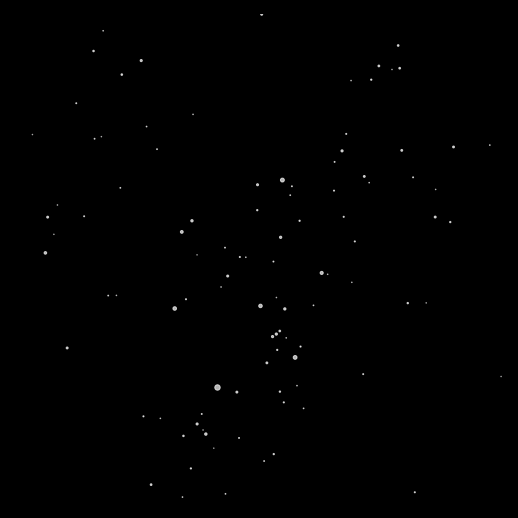

In [28]:
# set dark background
plt.style.use('dark_background')
position = np.array([22.0250, 88.0583])
observer = Topos(latitude_degrees = position[0], longitude_degrees=position[1])
print('Creating sky For :',times[1][0], position)

# create sky
plot_sky(t = times[0][0], observer = observer, cloud_cover=0/8, save_images=False)

Above we see a synthetic image of the night sky for one of our training positions and times. We chose to use a limiting star magnitude of 3.5, so only the brighter stars in the night sky are visible. 

### Clouds 

The clarity of the night sky is never a given. 

Our night sky plotting function allows for the random placement of clouds according by a specified proportion of cloud cover. While the model trained for this project was trained on images of the sky free of cloud cover, the functionality is there and we leave it as an area of further development. 

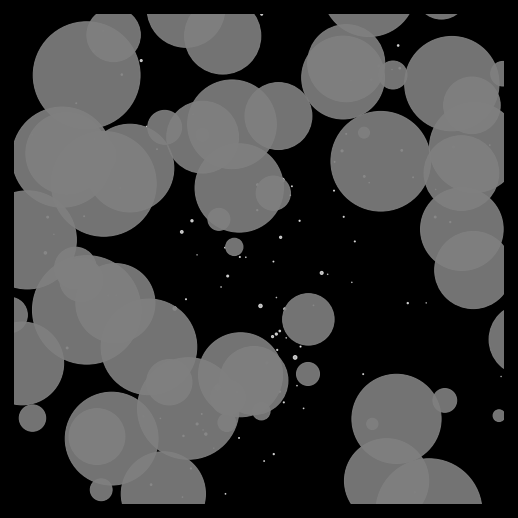

In [29]:

plot_sky(t = times[0][0], observer = observer, cloud_cover=5/8, save_images=False);